In [17]:
# %conda install tensorflow
# %conda install torch

### Imports
import numpy as np

import gym
from tqdm import tqdm
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [18]:
def average_every_ten(episode_durations):
    averages = []
    for start in tqdm(range(0, len(episode_durations), 10)):
        end = start + 10
        chunk = episode_durations[start:end]
        if chunk:  # Ensure the chunk is not empty
            average = sum(chunk) / len(chunk)
            averages.append(average)
    return averages

## Problem 1.
Implement the MDP using the gym Env class. The game resets once the agent finds the treasure ($r=10$). $\gamma = 0.9$. Each state has $4$ actions which moves left, right, up and down, respectively. If the agent moves against a wall, it will remain in the current state.

In [19]:
# If GPU is available, use it; otherwise, use CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class GridworldEnv(gym.Env):
    def __init__(self):
        # Define the grid
        self.grid = torch.tensor([[10, 0, 0, 0],
                                  [0 , 0, 0, 0],
                                  [0 , 0, 0, 0],
                                  [0 , 0, 0, 0]], device=device, dtype=torch.float)

        # Define the start and treasure positions
        self.start_pos = (3,0)
        self.treasure_pos = (0,0)

        # Define the action space
        self.action_space = gym.spaces.Discrete(4)

        # Define the observation as current_row * ncols + current_col
        # Thus, observation space:
        self.observation_space = gym.spaces.Discrete(16)
        # print(self.observation_space)

        # Set the discount factor
        self.gamma = 0.9

    def reset(self):
        # Reset the agent's position to the start
        self.state = self.start_pos
        pos = [0]*16
        pos[self.state[0] * 4 + self.state[1]] = 1

        # Return the initial observation
        return pos  # Add batch dimension

    def step(self, action):
        
        invalid_statesUP = [(1,0), (1,1), (1,2)]
        invalid_statesDOWN = [(0,0), (0,1), (0,2)]


        if self.state in invalid_statesUP and action == 3:
            action = random.choice([0, 1, 2])
        elif self.state in invalid_statesDOWN and action == 1: 
            action = random.choice([0, 2, 3])

        # Get the current state
        (currX, currY) = self.state

        # Move the agent based on the action
        if action == 0:  # Left
            next_state = (currX, currY - 1)
        elif action == 1:  # Down
            next_state = (currX + 1, currY)
        elif action == 2: # Right
            next_state = (currX, currY + 1)
        elif action == 3: # Up
            next_state = (currX - 1, currY)
        else:
            raise ValueError("Invalid action")

        # Check if the agent hit a wall
        (nextX, nextY) = next_state
        if nextX < 0 or nextX >= 4 or nextY < 0 or nextY >= 4:
            next_state = self.state

        # Check if the agent found the treasure
        if next_state == self.treasure_pos:
            reward = 10
            done = True
            self.reset()
        else:
            reward = 0
            done = False

        # Update the state
        self.state = next_state

        # print(self.state)

        # Return the next observation, reward, and done flag
        pos = [0]*16
        pos[self.state[0] * 4 + self.state[1]] = 1

        return pos, reward, done, {}


    def render(self, mode="human"):
        # Print the grid
        ren = self.grid.clone().detach().tolist()
        (x,y) = self.state
        ren[x][y] = 'A'
        print(np.array(ren),"\n")

## Problem 2.
Implement the DQN algorithm (with experience replay and target network) with $\epsilon$-greedy exploration, i.e. the agent use the action $a_t = \arg\max_a Q_t(s_t)$ with probability $1-\epsilon$ and $a_t = \text{Unif}(A)$ with probability $\epsilon$. You are free to tune $\epsilon$ as well as other hyper-parameters in DQN as you wish. Use a two-layer MLP for the Q-network. 
- Plot the learning curve averaging over 10 runs. The learning curve measures the performance of the policy $J(\pi_t)$ as a function of episode index $t$.
- Implement double DQN, and plot its learning curve in the same graph as above.

In [20]:
# Named tuple for storing transitions
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward'))

# Replay memory to store and sample transitions
class ReplayMemory(object):
    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)

In [21]:
class DQN(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(DQN, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, n_actions)  # Two-layer MLP

    def forward(self, x):
        x = F.relu(self.layer1(x))
        return self.layer2(x)  # Q-values for each action

In [22]:
# Hyperparameters
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
BATCH_SIZE = 15

# Initialize the Gridworld environment
env = GridworldEnv()

# Get the number of actions and observations
n_actions = env.action_space.n
n_observations = 16

# Initialize Q-networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initialize optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=5e-1, amsgrad=True)
memory = ReplayMemory(10000)

#-------------------------------------------------------------------------------------#

# Function for selecting actions with ϵ-greedy exploration
def select_action(state, policy_net, steps_done):
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    sample = random.random()
    if sample > eps_threshold:
        with torch.no_grad():
            # Ensure state has batch dimension and correct shape
            state = state.unsqueeze(0)
            q_values = policy_net(state)

            # print(state)
            # print(q_values)

            action = q_values.argmax(dim=1)
            return action.item()
    else:
        return env.action_space.sample()
    
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    
    
    # Filter out None values
    # Stack the filtered tensors along a new dimension (for example, dimension 0)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None], dim=0).to(device)

    
    # non_final_next_states = torch.tensor([[s for s in batch.next_state if s is not None]], device=device).t()
    
    # state_batch = torch.tensor([batch.state], device=device).t()
    # action_batch = torch.tensor([batch.action], device=device).t()
    # reward_batch = torch.tensor([batch.reward], device=device).t()
    # Assuming batch.state, batch.action, and batch.reward are lists of tensors
    state_batch = torch.stack(batch.state, dim=0).to(device)
    action_batch = torch.stack(batch.action, dim=0).to(device)
    reward_batch = torch.stack(batch.reward, dim=0).to(device)


    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(dim=1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * env.gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]c:\Users\jackw\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:933: UserWarning: Using a target size (torch.Size([15, 1, 15])) that is different to the input size (torch.Size([15, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction, beta=self.beta)
100%|██████████| 100/100 [00:00<?, ?it/s]

Complete


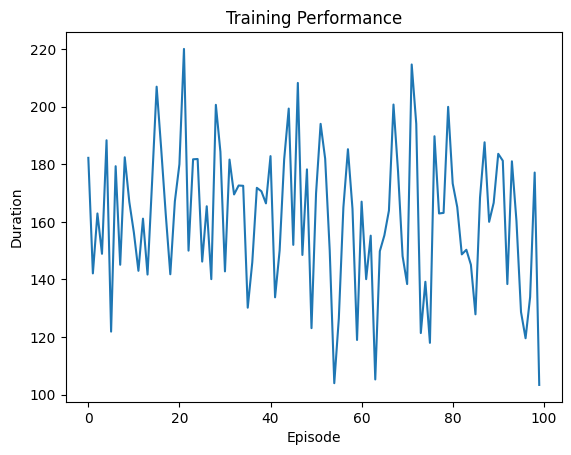

In [23]:
# Training loop
num_episodes = 1000
episode_durations = []

for i_episode in tqdm(range(num_episodes)):
    state = torch.tensor(env.reset(), device=device, dtype=torch.float)
    # print("state:", state)
    for t in count():
        action = select_action(state, policy_net, t)
        observation, reward, done, _ = env.step(action)
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.tensor(observation, device=device, dtype=torch.float)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, torch.tensor([action], device=device), next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]* 0.005 + target_net_state_dict[key]*(1-0.005)
        target_net.load_state_dict(target_net_state_dict)

        if done or t > 250:
            episode_durations.append(t + 1)
            break

# Calculate averages
averaged_durations = average_every_ten(episode_durations)

print('Complete')
plt.plot(averaged_durations)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Training Performance')
plt.show()

In [24]:
# ##### PLAYING #####
# state = torch.tensor(env.reset(), device=device, dtype=torch.float)
# timer = 0
# while True:
#     # Render the environment
#     env.render()

#     # Get the agent's action
#     action = select_action(state, policy_net, timer)
#     # Take a step in the environment
#     next_state, reward, done, _ = env.step(action)

#     # Check if the game is over
#     if done:
#         print(f'time: {timer}')
#         break

#     # Update the state
#     state = torch.tensor(next_state, device=device, dtype=torch.float)
#     timer += 1

## DOUBLE DQN

In [25]:
# Initialize the Gridworld environment
env = GridworldEnv()

# Get the number of actions and observations
n_actions = env.action_space.n
n_observations = 16

# Initialize Q-networks
policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

# Initialize optimizer and replay memory
optimizer = optim.AdamW(policy_net.parameters(), lr=5e-1, amsgrad=True)
memory = ReplayMemory(10000)

In [26]:
def optimize_model2():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    batch = Transition(*zip(*transitions))

    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None, batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.stack([s for s in batch.next_state if s is not None], dim=0).to(device)
    state_batch = torch.stack(batch.state, dim=0).to(device)
    action_batch = torch.stack(batch.action, dim=0).to(device)
    reward_batch = torch.stack(batch.reward, dim=0).to(device)

    # Proceed with the gather operation if shapes are as expected
    state_action_values = policy_net(state_batch).gather(1, action_batch.reshape(-1, 1))

    # 1. Select action according to policy net
    policy_net_actions = policy_net(non_final_next_states).max(1)[1].unsqueeze(1)
    # 2. Evaluate the action by target net
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    next_state_values[non_final_mask] = target_net(non_final_next_states).gather(1, policy_net_actions).squeeze().detach()

    # Compute the expected Q values
    expected_state_action_values = (next_state_values * env.gamma) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values)

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()


100%|██████████| 100/100 [00:00<00:00, 100390.23it/s]


Complete


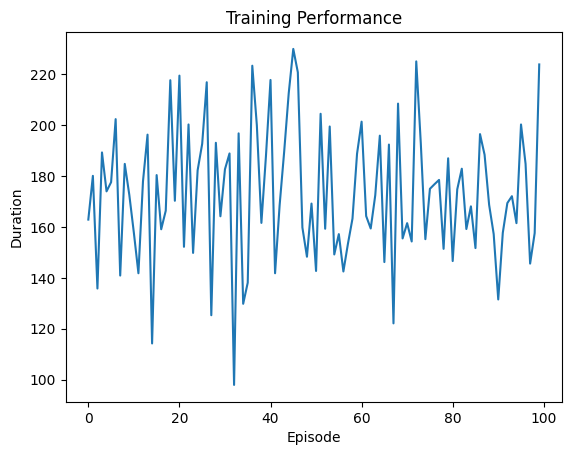

In [27]:
# Training loop
num_episodes = 1000
episode_durations = []

for i_episode in tqdm(range(num_episodes)):
    state = torch.tensor(env.reset(), device=device, dtype=torch.float)
    # print("state:", state)
    for t in count():
        action = select_action(state, policy_net, t)
        observation, reward, done, _ = env.step(action)
        reward = torch.tensor([reward], device=device)

        if not done:
            next_state = torch.tensor(observation, device=device, dtype=torch.float)
        else:
            next_state = None

        # Store the transition in memory
        memory.push(state, torch.tensor([action], device=device), next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model2()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]* 0.005 + target_net_state_dict[key]*(1-0.005)
        target_net.load_state_dict(target_net_state_dict)

        if done or t > 250:
            episode_durations.append(t + 1)
            break

# Calculate averages
averaged_durations = average_every_ten(episode_durations)

print('Complete')
plt.plot(averaged_durations)
plt.xlabel('Episode')
plt.ylabel('Duration')
plt.title('Training Performance')
plt.show()

## Problem 3
Implement the vanilla REINFORCE algorithm using a two-layer MLP network with softmax output layer. You can tune the mini-batch size and learning rate as you wish.
- Plot the learning curve averaging over 10 runs.
- Plot the learning curve using the $V^*$ function as a baseline for variance reduction.
- Plot the empirical variance of policy gradient with and without baseline. Given a set of trajectories $\tau_{1:n}$ from a policy $\pi_t$, the empirical variance is 
    $
    \begin{align*}
        v_t= \frac{1}{n} \sum_{i=1}^n ||g_{t;i}-g_t||_2^2
    \end{align*}
    where 
    \begin{align*}
    g_{t;i}&=\sum_{h=0}^\infty \nabla_\theta\log\pi(a_{i;h}|s_{i;h}) (R(s_{i;h},a_{i;h})- \text{baseline}(s_{i;h}))\\
    g_t &= \frac{1}{n} \sum_{i=1}^n g_{t;i}
    \end{align*}
    $

In [45]:
import gym
import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count

import torch
import torch.nn as nn
import torch.optim as optim

# Define the environment
env = GridworldEnv()

# State and action space dimensions
n_observations = 16
n_actions = env.action_space.n

# Define the policy network as a two-layer MLP with a softmax output layer representing action probabilities.

class PolicyNet(nn.Module):
    def __init__(self, n_observations, n_actions):
        super(PolicyNet, self).__init__()
        self.fc1 = nn.Linear(n_observations, 128)
        self.fc2 = nn.Linear(128, n_actions)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.softmax(self.fc2(x))
        return x

# Initialize policy network and optimizer
policy_net = PolicyNet(n_observations, n_actions).to(device)
optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)  # Tune learning rate

In [46]:
# Hyperparameters
GAMMA = 0.9
BATCH_SIZE = 20  # Tune mini-batch size
EPISODES = 1000

# Episode duration storage
episode_durations = []
all_gradients = []
V_star = [0]*EPISODES

for episode in tqdm(range(EPISODES)):
    # Reset environment and initialize episode
    state = env.reset()
    episode_reward = 0
    done = False
    states, actions, rewards = [], [], []

    while not done:
        # Convert state to tensor
        state_tensor = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

        # Get action probabilities from policy network
        action_probs = policy_net(state_tensor)

        V_star[episode] += action_probs.max().item()

        action = torch.multinomial(action_probs, 1).item()
        new_state, reward, done, _ = env.step(action)

        # Store transition
        states.append(state)
        actions.append(action)
        rewards.append(reward)

        episode_reward += reward
        state = new_state

    # Compute discounted returns
    returns = []
    G = 0
    for reward in rewards[::-1]:
        G = reward + GAMMA * G
        returns.insert(0, G)

    # Normalize returns
    returns = torch.tensor(returns, dtype=torch.float).to(device)
    returns = (returns - returns.mean()) / (returns.std() + 1e-5)

    # Convert lists to tensors
    states = torch.tensor(states, device=device, dtype=torch.float)
    actions = torch.tensor(actions, device=device, dtype=torch.long)

    # Gradient calculation
    log_probs = torch.log(policy_net(states))
    action_log_probs = log_probs[range(len(actions)), actions]
    loss = -(returns * action_log_probs).mean()

    # Policy update
    optimizer.zero_grad()
    loss.backward()

    # Store gradients
    gradients = []
    for param in policy_net.parameters():
        gradients.append(param.grad.view(-1))
    all_gradients.append(torch.cat(gradients))

    optimizer.step()

    # Track episode duration
    episode_durations.append(len(states))

    # print(f"Episode: {episode+1}, Reward: {episode_reward}")

## new
e_variances = []
for gradients in all_gradients:
    gt = torch.stack([gradients[i] for i in range(len(gradients))]).mean(0)
    vt = ((gradients - gt) ** 2).mean(0).item()
    e_variances.append(vt)
## new

averaged_durations = average_every_ten(episode_durations)
averaged_vstar = average_every_ten(V_star)

100%|██████████| 100/100 [00:00<?, ?it/s]


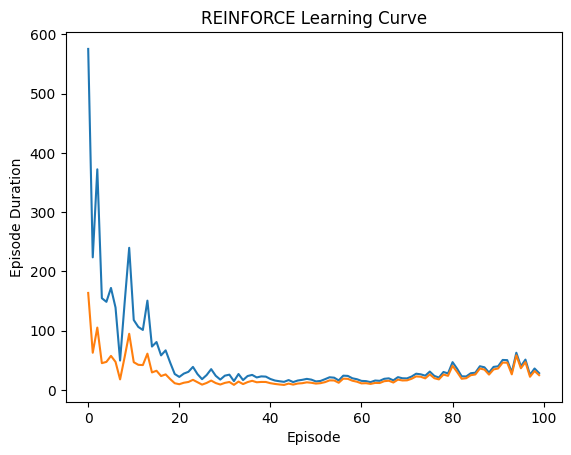

In [47]:
# Plot learning curve
plt.plot(averaged_durations)
plt.plot(averaged_vstar)
plt.xlabel("Episode")
plt.ylabel("Episode Duration")
plt.title("REINFORCE Learning Curve")
plt.show()

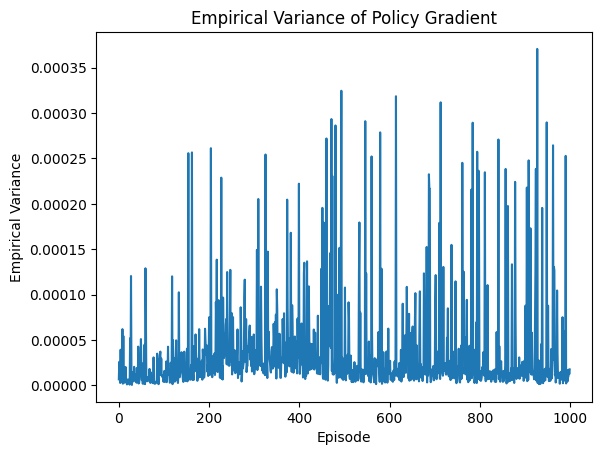

In [43]:
plt.figure()
plt.plot(e_variances)
plt.xlabel("Episode")
plt.ylabel("Empirical Variance")
plt.title("Empirical Variance of Policy Gradient")
plt.show()

In [44]:
# state = env.reset()
# timer = 0
# while True:
#     # Render the environment
#     env.render()

#     state_tensor = torch.tensor(state, device=device, dtype=torch.float).unsqueeze(0)

#     # Get action probabilities from policy network
#     action_probs = policy_net(state_tensor)

#     # Sample action based on probabilities
#     action = torch.multinomial(action_probs, 1).item()

#     # Take action and observe reward
#     new_state, reward, done, _ = env.step(action)

#     # Check if the game is over
#     if done:
#         print(f'time: {timer}')
#         break

#     # Update the state
#     state = new_state
#     timer += 1